<a href="https://colab.research.google.com/github/Yoshiki0418/Deep_Learning/blob/main/DL_Lecture2/optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# googleドライブをマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Deep_Learning/DL_Lecture2

/content/drive/MyDrive/Deep_Learning/DL_Lecture2


## Optimizer

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import init
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch import nn, optim
import torchvision
from torchvision import transforms

%load_ext autoreload
%autoreload 2
import utils

### EMA

In [4]:
x = np.linspace(0, 2*np.pi, 10)
y = np.sin(x)

# EMA
ema = 0
alpha = 0.8
results = []
for y_i in y:
    ema = alpha * ema + (1-alpha) * y_i
    results.append(ema)

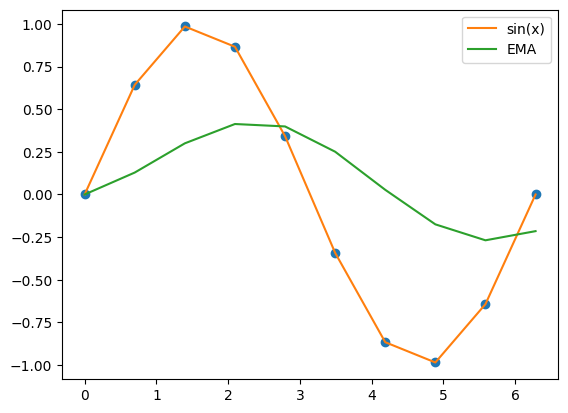

In [5]:
plt.plot(x, y, 'o')
plt.plot(x, y, '-', label='sin(x)')
plt.plot(x, results, label='EMA')
plt.legend()

### Momentum

In [6]:
class Optimizer():

    def __init__(self, parameters, lr=0.03):
        self.parameters = list(parameters)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for param in self.parameters:
                param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.parameters:
            if param.grad is not None:
                param.grad.zero_()

In [12]:
class MomentumOptimizer():
    def __init__(self, parameters, lr=0.03, momentum=0.9):
        self.parameters = list(parameters)
        self.lr = lr
        self.momentum = momentum
        self.v = [torch.zeros_like(param) for param in self.parameters]

    def step(self):
        with torch.no_grad():
            for param, v in zip(self.parameters, self.v):
                v[:] = self.momentum * v + param.grad
                param -= self.lr * v

    def zero_grad(self):
        for param in self.parameters:
            if param.grad is not None:
                param.grad.zero_()

In [15]:
conv_model = utils.get_conv_model()
# データ準備
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,) )
])
train_dataset = torchvision.datasets.FashionMNIST('./fmnist_data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.FashionMNIST('./fmnist_data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1024, num_workers=4)
# pytorchでのモーメンタム適用
opt = optim.SGD(conv_model.parameters(), lr=0.03, momentum=0.9)

In [16]:
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, 3)

epoch: 0: train error: 1.4600920859029738, validation error: 0.8807329773902893, validation accuracy: 0.7013372898101806


epoch: 1: train error: 0.685451407553786, validation error: 0.6269776284694671, validation accuracy: 0.7722476899623871


epoch: 2: train error: 0.5522513086512938, validation error: 0.5456993699073791, validation accuracy: 0.7986049115657806


In [17]:
# スクラッチでモーメンタムを適用
opt = MomentumOptimizer(conv_model.parameters(), lr=0.03, momentum=0.9)

In [18]:
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, 3)

epoch: 0: train error: 0.49476769414998717, validation error: 0.5085733830928802, validation accuracy: 0.8121392726898193


epoch: 1: train error: 0.45520444088063, validation error: 0.4711390346288681, validation accuracy: 0.8267418682575226


epoch: 2: train error: 0.42693298903562255, validation error: 0.4473032712936401, validation accuracy: 0.8365812361240387


### RMSProp

In [19]:
class RMSPropOptimizer():
    def __init__(self, parameters, lr=0.03, beta=0.9, eps=1e-8):
        self.parameters = list(parameters)
        self.lr = lr
        self.beta = beta
        self.eps = eps
        self.sqr_avg = [torch.zeros_like(param) for param in self.parameters]

    def step(self):
        with torch.no_grad():
            for param, sqr_avg in zip(self.parameters, self.sqr_avg):
                sqr_avg[:] = self.beta * sqr_avg + (1-self.beta) * param.grad**2
                param -= self.lr * param.grad/(torch.sqrt(sqr_avg)+self.eps)

    def zero_grad(self):
        for param in self.parameters:
            if param.grad is not None:
                param.grad.zero_()

In [20]:
conv_model = utils.get_conv_model()
# RMSPropをスクラッチで実装
opt = RMSPropOptimizer(conv_model.parameters(), lr=0.03, beta=0.9)
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, 3)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
                                                          

epoch: 0: train error: 0.7309966127751237, validation error: 0.6661085486412048, validation accuracy: 0.7303033351898194


epoch: 1: train error: 0.44196180872998, validation error: 0.45722003281116486, validation accuracy: 0.8233677446842194


epoch: 2: train error: 0.384594253564285, validation error: 0.42473518252372744, validation accuracy: 0.8425741374492646


In [21]:
# PytorchでRMSPropを実装
opt = optim.RMSprop(conv_model.parameters(), lr=0.03, alpha=0.9)
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, 3)

epoch: 0: train error: 0.3798843945487071, validation error: 0.44256948232650756, validation accuracy: 0.8409658014774323


epoch: 1: train error: 0.34034899634830024, validation error: 0.3634831339120865, validation accuracy: 0.8657684922218323


epoch: 2: train error: 0.3286377191543579, validation error: 0.43816173672676084, validation accuracy: 0.8389688313007355


### バイアス補正

In [22]:
# バイアス補正追加バージョン
class RMSPropOptimizer():

    def __init__(self, parameters, lr=0.03, beta=0.9, eps=1e-8):
        self.parameters = list(parameters)
        self.lr = lr
        self.beta = beta
        self.eps = eps
        self.sqr_avg = [torch.zeros_like(param) for param in self.parameters]
        self.t = 0 # カウント用

    def step(self):
        self.t += 1
        with torch.no_grad():
            for param, sqr_avg in zip(self.parameters, self.sqr_avg):
                sqr_avg[:] = self.beta * sqr_avg + (1-self.beta) * param.grad**2
                sqr_avg_corrected = sqr_avg / (1-self.beta**self.t)
                param -= self.lr * param.grad/(torch.sqrt(sqr_avg_corrected)+self.eps)

    def zero_grad(self):
        for param in self.parameters:
            if param.grad is not None:
                param.grad.zero_()

In [23]:
conv_model = utils.get_conv_model()
opt = RMSPropOptimizer(conv_model.parameters(), lr=0.03, beta=0.9)
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, 3)

epoch: 0: train error: 0.769629357729928, validation error: 0.5506061375141144, validation accuracy: 0.8021484375


epoch: 1: train error: 0.46891732286598725, validation error: 0.5555547714233399, validation accuracy: 0.794614952802658


epoch: 2: train error: 0.4052731672586021, validation error: 0.45894678235054015, validation accuracy: 0.8300980567932129


### Adam

In [24]:
class AdamOptimizer():

    def __init__(self, parameters, lr=0.03, beta1=0.9, beta2=0.999, eps=1e-8):
        self.parameters = list(parameters)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.v = [torch.zeros_like(param) for param in self.parameters]
        self.s = [torch.zeros_like(param) for param in self.parameters]
        self.t = 0 # カウント用

    def step(self):
        self.t += 1
        with torch.no_grad():
            for param, v, s in zip(self.parameters, self.v, self.s):
                # 1次モーメント
                v[:] = self.beta1 * v + (1-self.beta1) * param.grad
                v_corrected = v / (1-self.beta1**self.t)
                # 2次モーメント
                s[:] = self.beta2 * s + (1-self.beta2) * param.grad**2
                s_corrected = s / (1-self.beta2**self.t)
                # パラメータ更新
                param -= self.lr * v_corrected/(torch.sqrt(s_corrected)+self.eps)

    def zero_grad(self):
        for param in self.parameters:
            if param.grad is not None:
                param.grad.zero_()

In [25]:
conv_model = utils.get_conv_model()
opt = AdamOptimizer(conv_model.parameters(), lr=0.03, beta1=0.9, beta2=0.999)
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, 3)

epoch: 0: train error: 0.6929511650133942, validation error: 0.5211655646562576, validation accuracy: 0.8098333835601806


epoch: 1: train error: 0.39320527800058913, validation error: 0.4574600368738174, validation accuracy: 0.8320133149623871


epoch: 2: train error: 0.3475298401662859, validation error: 0.3759265929460526, validation accuracy: 0.8654376566410065


In [26]:
conv_model = utils.get_conv_model()
# PytorchのAdam
opt = optim.Adam(conv_model.parameters(), lr=0.03)
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, 3)

epoch: 0: train error: 0.6661411564228898, validation error: 0.4990744203329086, validation accuracy: 0.8224370241165161


epoch: 1: train error: 0.3817627232963756, validation error: 0.41101557612419126, validation accuracy: 0.8502949595451355


epoch: 2: train error: 0.3412802471952923, validation error: 0.40456771552562715, validation accuracy: 0.8451949119567871
